# Customer Acquisition and Rentention using Experian Data

### Background

Business can purchase data from Experian to get more insight about their customers.
<br>
The data return back will reflect customer's interest, hobby, etc.

The data contain customers' subscription status and the customer's data from Experian Data. 
<br>
Subscription Status is base on after a free trial subscription. 
<br>
Active: users continue to subscripe after trial.<br>
Cancel/Expire: users op out of the subscription after trial.


### Goal

To find out if there is difference between customers that are still subscribing(Active group) vs customers that cancel(Cancel group) base on these data.

E.g.: if the "Active customers" had a significant higher or lower "Play Golf Value" than the "Cancel customers", then this information can be use to target better customers, result in higher conversion on new customer acquisition or better retention on existing customers. 

### Import all necessary library

In [430]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as stats
plt.style.use('seaborn')
%matplotlib inline

### Load and Clean
- Load the Data, remove all trailing space in column name
- Preview  the data structure

In [431]:
df = pd.read_csv("../Data/Subscription and Experian.csv")
df.columns = df.columns.str.strip()

In [432]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 33 columns):
Sub Type                          20000 non-null object
Sub Status                        20000 non-null object
city                              20000 non-null object
state                             20000 non-null object
american express/premium          15745 non-null object
american express/regular          15745 non-null object
discover/premium                  15745 non-null object
discover/regular                  15745 non-null object
other card/premium                15745 non-null object
other card/regular                15745 non-null object
store or retail/regular           15745 non-null object
visa/regular                      15745 non-null object
mastercard/regular                15745 non-null object
person 1: technology adoption     19931 non-null float64
person 1: health well being       19931 non-null float64
act/int: wine lovers              17300 non-null 

Data Cleaning
- from the data structure information above, the Data contain 20000 rows
- For the Catergorical Data, from "american express/premium" to "mastercard/regular", there are 15745 rows of non-null data.
- For the numerical data, from "person 1: technology adoption" and beyond, there are 17052 non-null data.
- a heatmap of missing data is create below to see it in a graphic way.

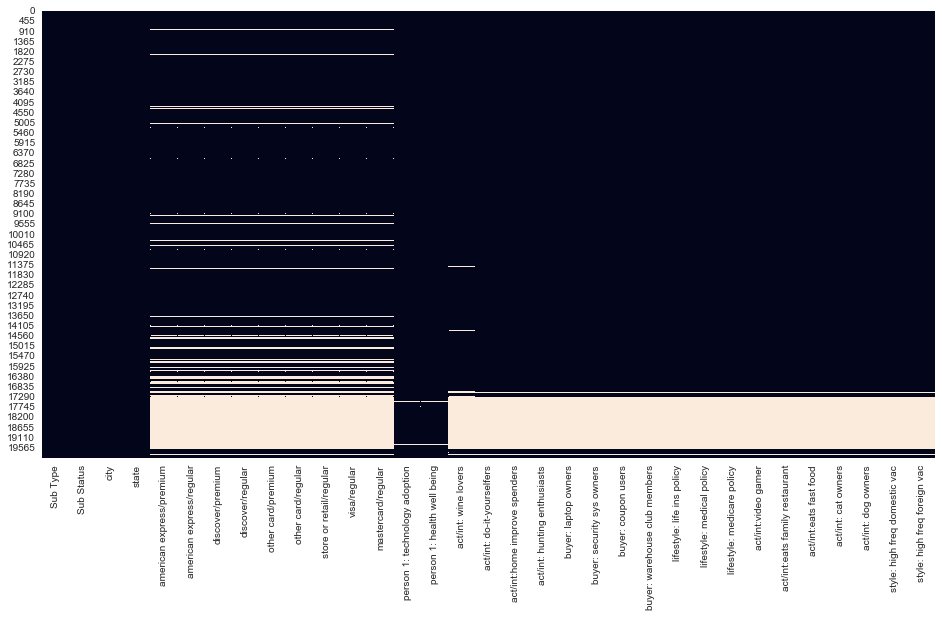

In [433]:
plt.figure(figsize=(16,8))
sns.heatmap(df.isnull(),cbar=False)

The heatmap reinforce the difference between missing data for the catergorical and numerical data.

Since when a data is missing in the caterogrial or numerical, the whole row of data seems to missing as well. I decide to drop all the missing value since it doesn't contribute anything to my analaysis.
    
Since there is a difference between the Categorical and Numerical columns. Before I drop the value,I split the data into two respective dataframe.Both dataframe will keep the "Sub Type" and "Sub Status Column". 

In [434]:
# Catergorical dataframe call df_cat
df_cat = df.loc[:,"Sub Type":"person 1: health well being"]

# Numerical dataframe call df_num
A=df.loc[:,"Sub Type":"Sub Status"]
B= df.loc[:,"act/int: wine lovers":"style: high freq foreign vac"]
df_num = pd.concat([A,B],axis =1)


In [435]:
# Drop all missing value, replace the orignal dataframe
df_cat.dropna(inplace= True)
df_num.dropna(inplace=True)


Below is how the data structure for both dataframe looks like after I drop the missing values. Both dataframe has same number of rows in all column. 

In [436]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15745 entries, 0 to 19999
Data columns (total 15 columns):
Sub Type                         15745 non-null object
Sub Status                       15745 non-null object
city                             15745 non-null object
state                            15745 non-null object
american express/premium         15745 non-null object
american express/regular         15745 non-null object
discover/premium                 15745 non-null object
discover/regular                 15745 non-null object
other card/premium               15745 non-null object
other card/regular               15745 non-null object
store or retail/regular          15745 non-null object
visa/regular                     15745 non-null object
mastercard/regular               15745 non-null object
person 1: technology adoption    15745 non-null float64
person 1: health well being      15745 non-null float64
dtypes: float64(2), object(13)
memory usage: 1.9+ MB


In [437]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17296 entries, 0 to 19999
Data columns (total 20 columns):
Sub Type                          17296 non-null object
Sub Status                        17296 non-null object
act/int: wine lovers              17296 non-null float64
act/int: do-it-yourselfers        17296 non-null float64
act/int:home improve spenders     17296 non-null float64
act/int: hunting enthusiasts      17296 non-null float64
buyer: laptop owners              17296 non-null float64
buyer: security sys owners        17296 non-null float64
buyer: coupon users               17296 non-null float64
buyer: warehouse club members     17296 non-null float64
lifestyle: life ins policy        17296 non-null float64
lifestyle: medical policy         17296 non-null float64
lifestyle: medicare policy        17296 non-null float64
act/int:video gamer               17296 non-null float64
act/int:eats family restaurant    17296 non-null float64
act/int:eats fast food            1729

For this project, I will be only working on the numerical columns for now.
<BR>
Since I am trying to see the difference between the Active group vs the Cancel group, I will to split the numerical dataframe into a "Active" dataframe and ""Expired/Cancelled" dataframe. 

In [438]:
# Split the numerical DF to two group, one with active, one with cancel
df_num_act = df_num[df_num["Sub Status"] == "Active"]
df_num_cnl = df_num[df_num["Sub Status"] == "Expired/Cancelled"]

## Exploring the data.
- create a function to plot kernel density of one numerical column.

In [439]:
# Function to plot the distribution of two group of data in the same graph.

def compare_distribution(data1,data2):
    """
    For each of input data array, 
    return a plot of kernel density of the input data.
    Both plot will be on the same graph.
    data1 will be the active group data.
    data2 will be the inactive grouop data.
    
    Parameters
    ----------
    data1: 1-dimensional Array, numpy Array, Pandas Series.
    data2: 1-dimensional Array, numpy Array, Pandas Series.

    Returns
    -------
    Plot figure.
    """
    #Finding the mean and standard deviation of both data and store them.
    mu,mu2 = np.mean(data1),np.mean(data2)
    sd,sd2 = np.std(data1),np.std(data2)
    
    plt.figure(figsize=(16,8))
    
    #Set the title and put varibale to it's name.
    
    plt.title("{0}, Active(\u03bc={1},\u03C3={2}) vs Cancel(\u03bc={3},\u03C3={4})".format(data1.name,np.round(mu,2),np.round(sd,2),np.round(mu2,2),np.round(sd2,2)),fontsize=25)
    # Using seaborn KDE plot feature to graph both plot.
    sns.kdeplot(data1, label = "Active User")
    sns.kdeplot(data2,label ="Cancel User",alpha = 0.5)
    
    # Draw verticle dash line on the mean, anootate them.
    plt.axvline(mu, c="blue", linestyle ="--",label = "mu Active")
    plt.axvline(mu2, c="green", linestyle ="--",label = "mu Cancel")
    plt.xlabel("{} score".format(data1.name), fontsize=18)
    plt.annotate('Active mu = {}'.format(np.round(mu,2)), xy=(mu, 0),xytext=(mu-sd,0.002),arrowprops=dict(facecolor='black',width=0.2,headwidth=9))
    plt.annotate('Cancel mu = {}'.format(np.round(mu2,2)), xy=(mu2, 0),xytext=(mu2+sd2,0.002),arrowprops=dict(facecolor='black',width=0.2,headwidth=9))
    plt.legend(fontsize="large")


Calling the compare_distribution function create above will create a plot below.

By looking at the plot, we can get a better idea how the distribution of one column of numerical data looks like for each of the group. Knowing where the mean it is, and get a general idea of the difference.

For example, we can see that for the "wine lovers" column, both group has a positive skew distribution, with mode around 10, and the mean is 34.5 for the active group, 39.55 for the cancel group.  

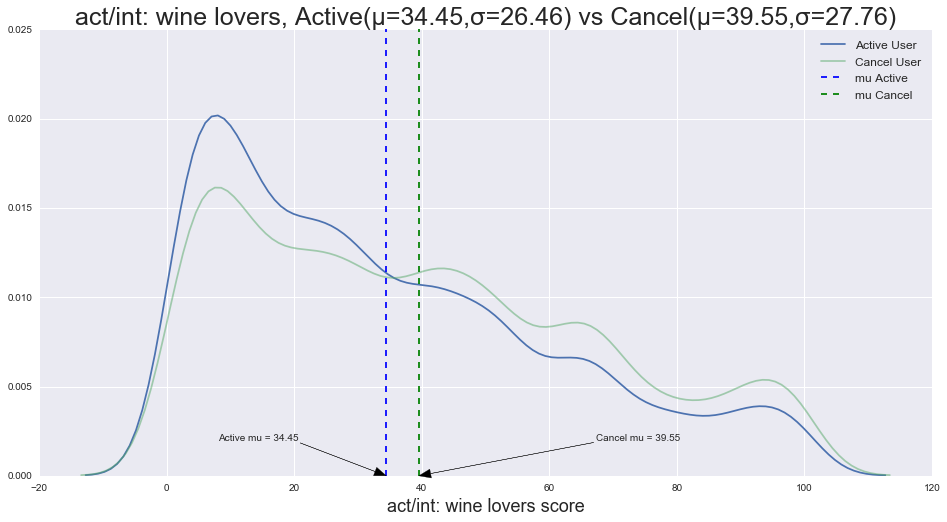

In [440]:
compare_distribution(df_num_act["act/int: wine lovers"],df_num_cnl["act/int: wine lovers"])

Using a for loop to go over every numerical column, store the image into a local image folder. 

With this, I can examine the distribution of each column individually. 

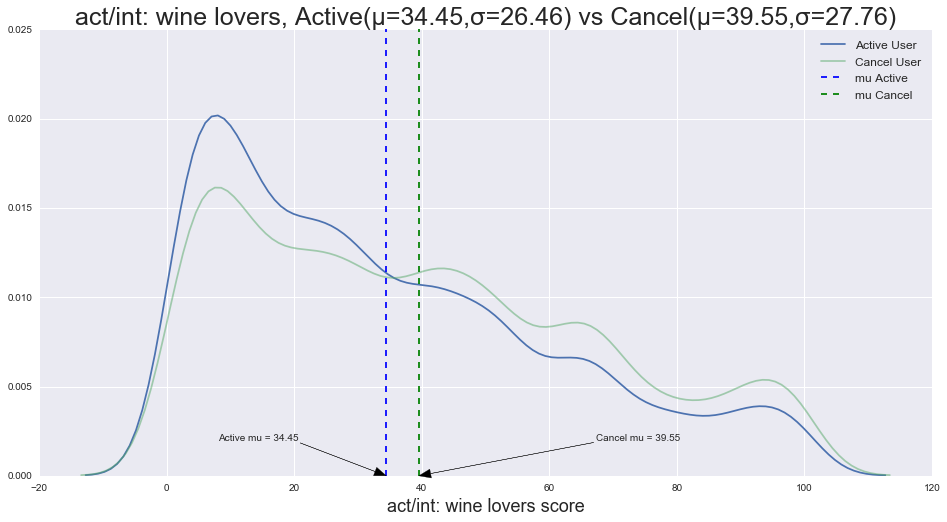

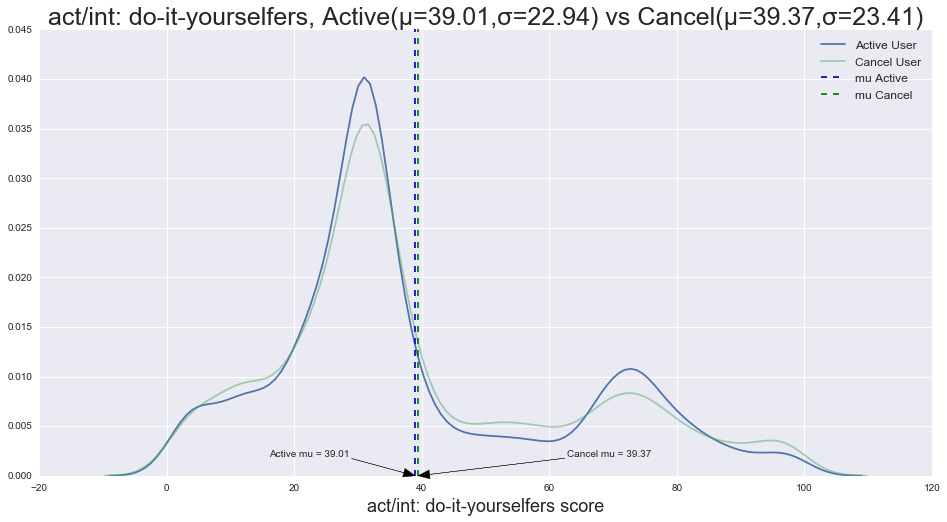

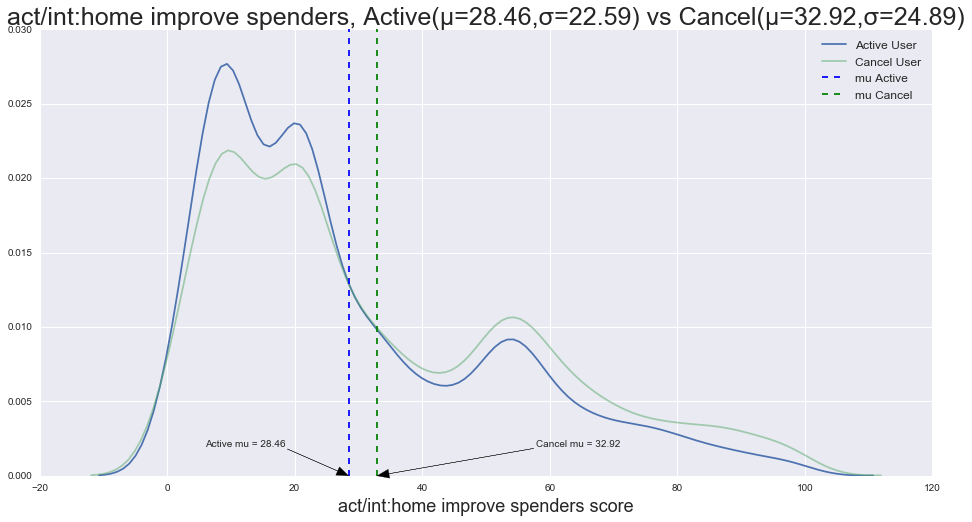

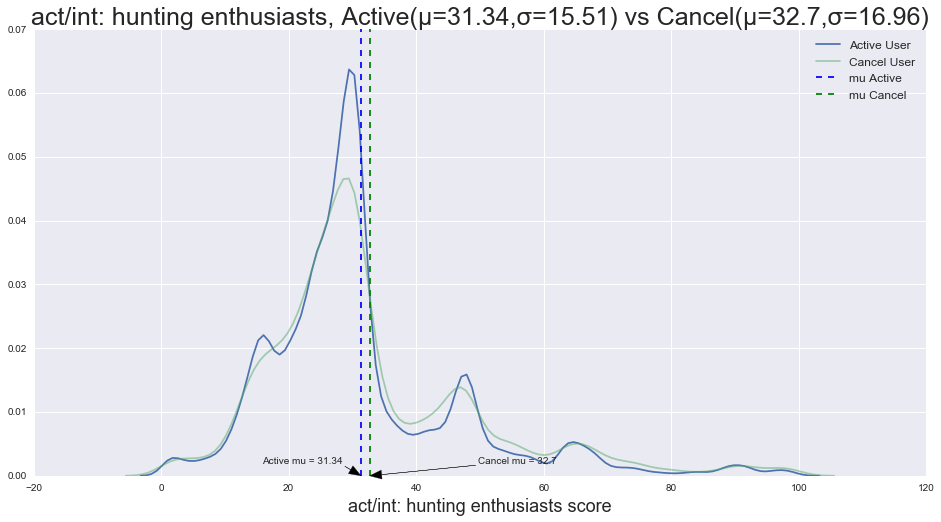

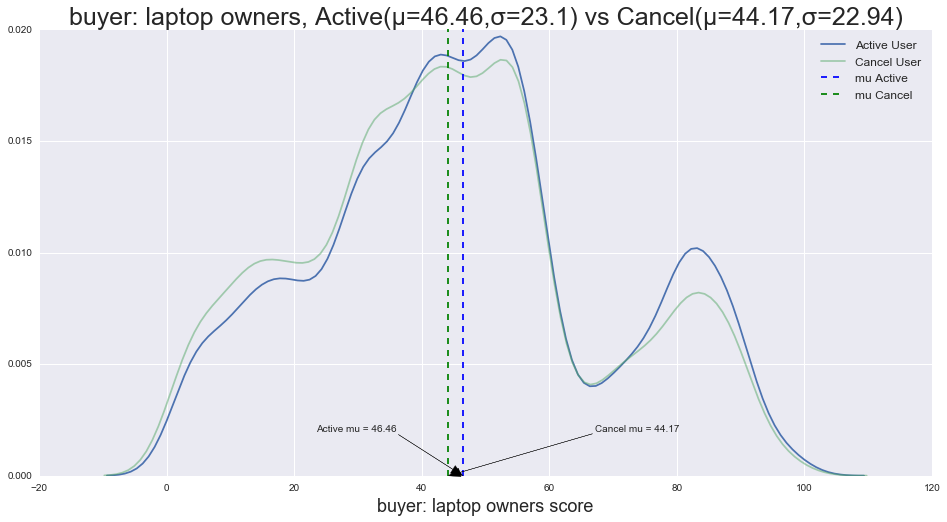

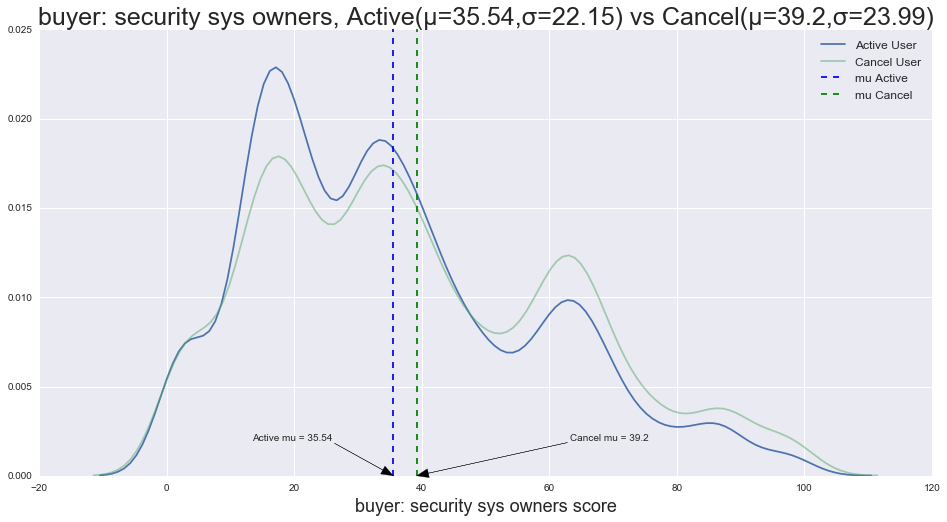

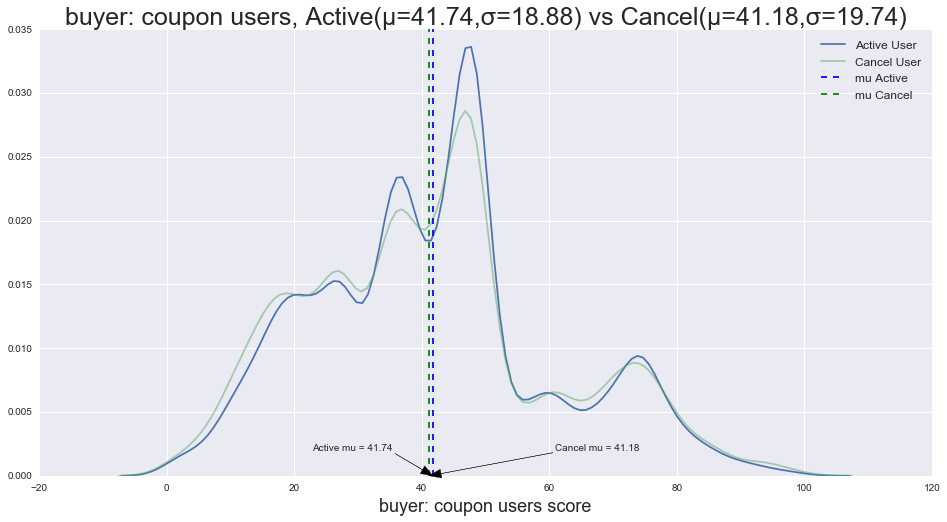

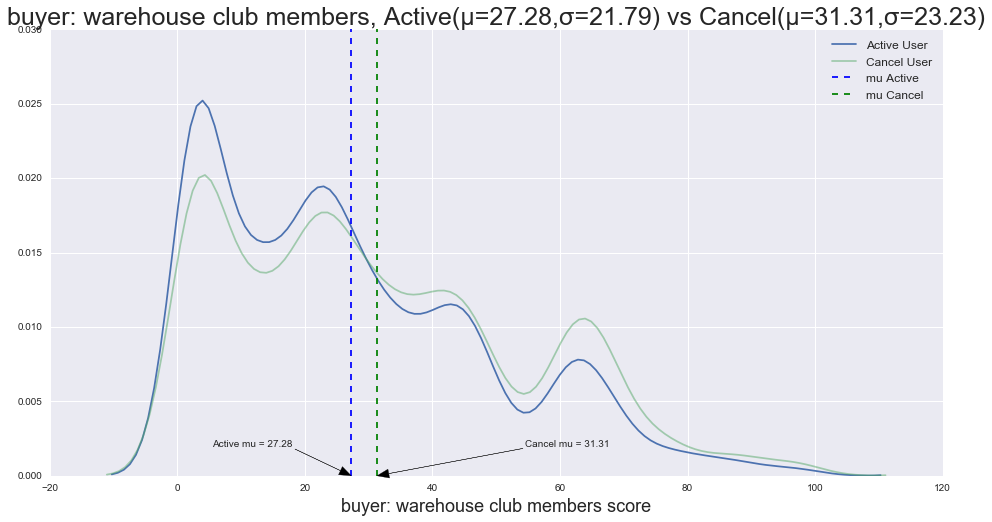

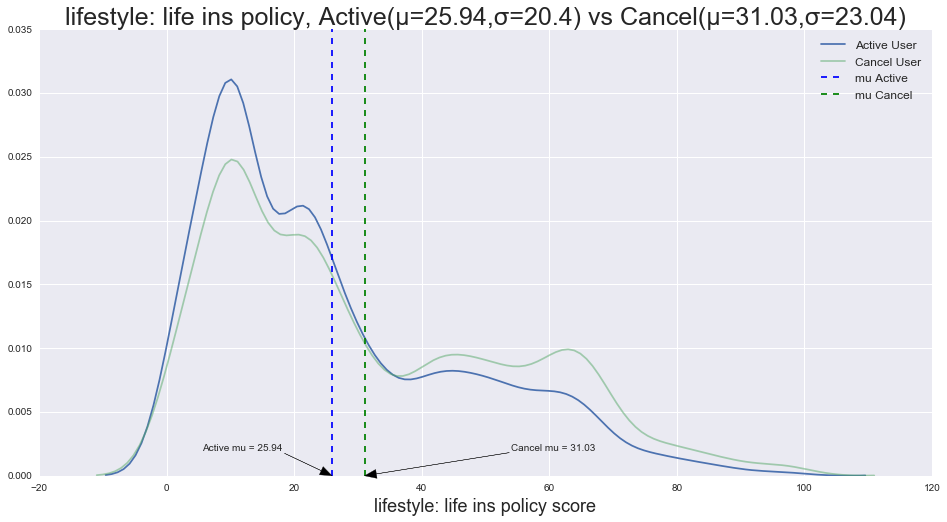

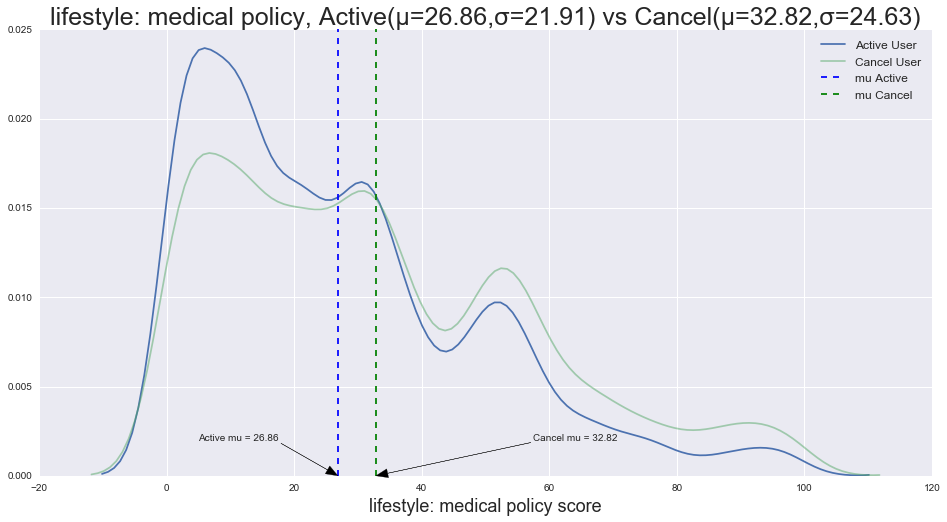

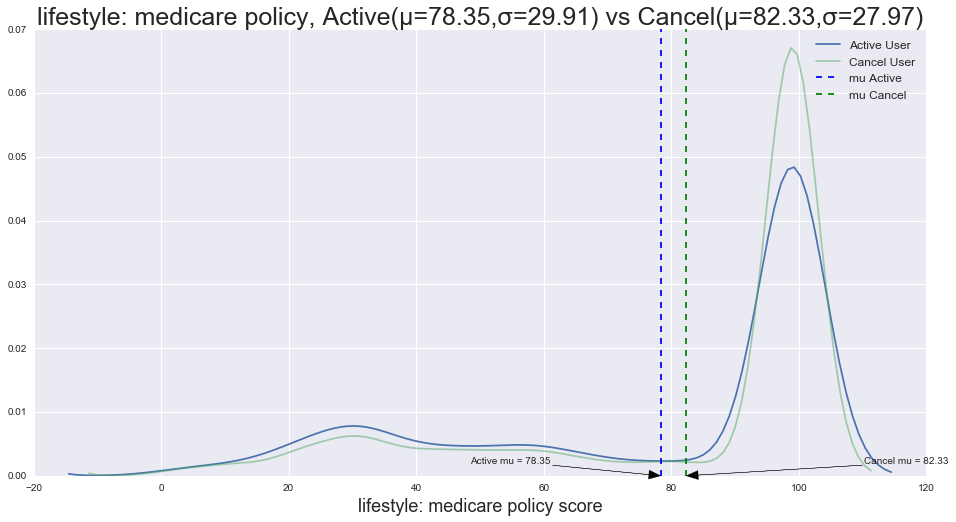

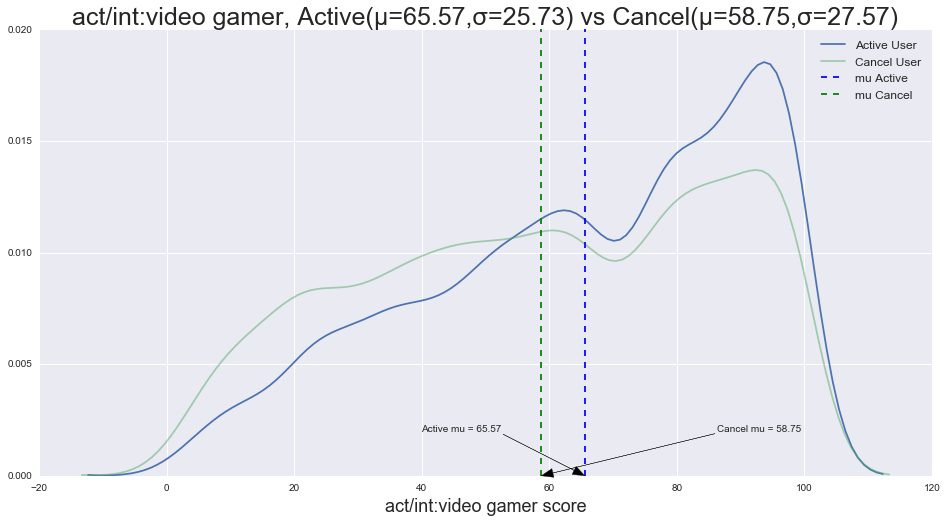

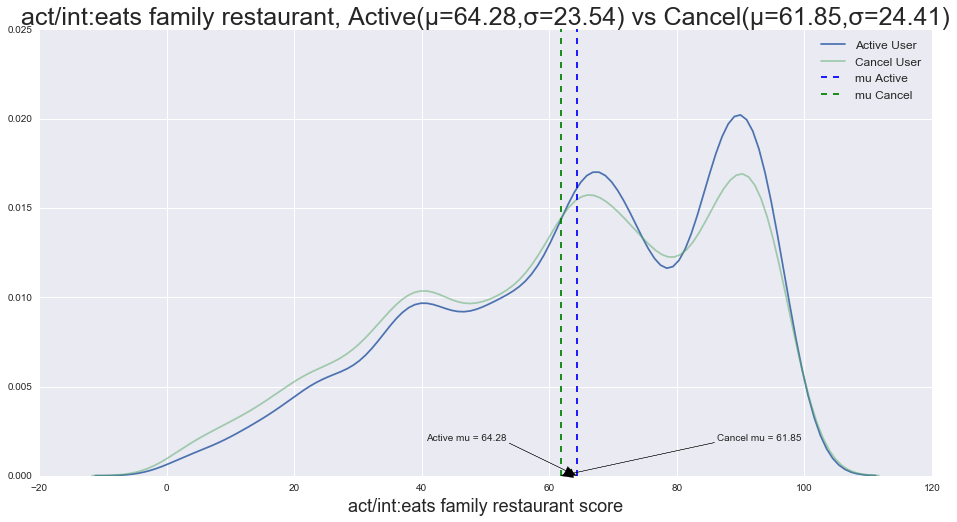

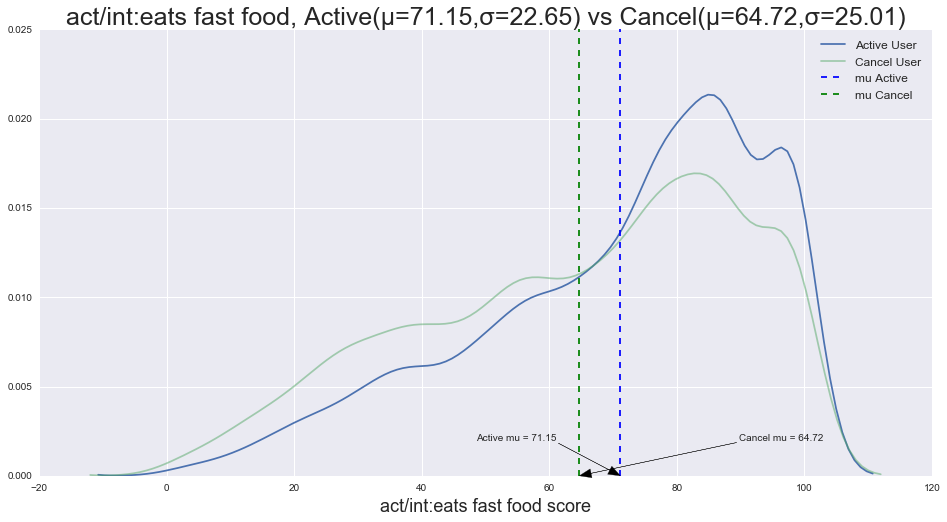

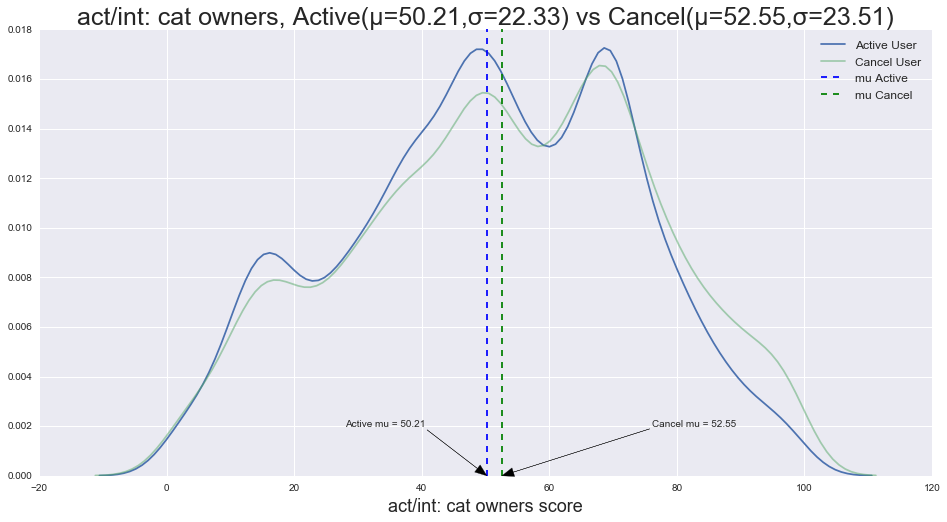

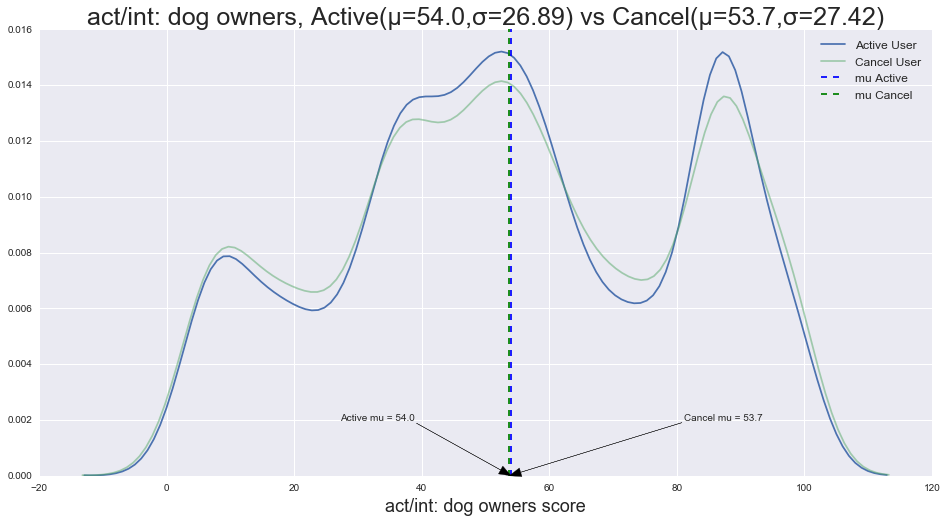

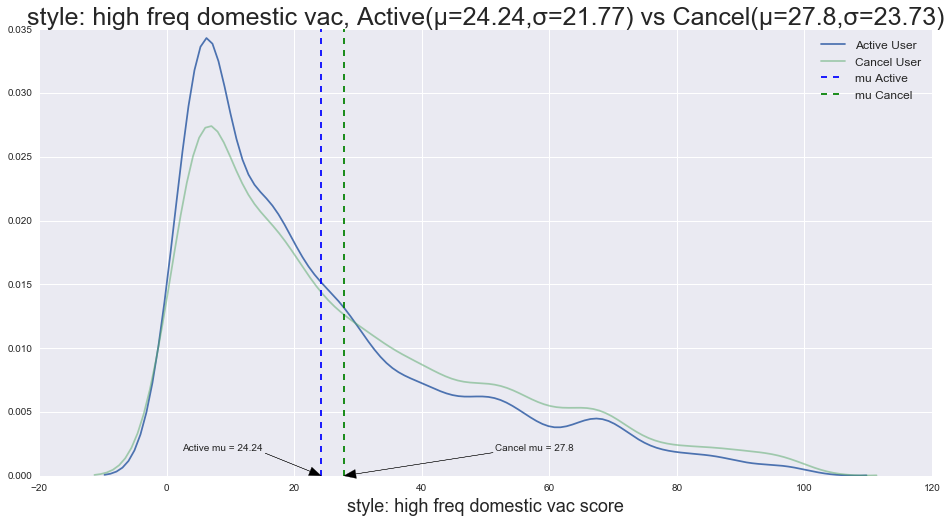

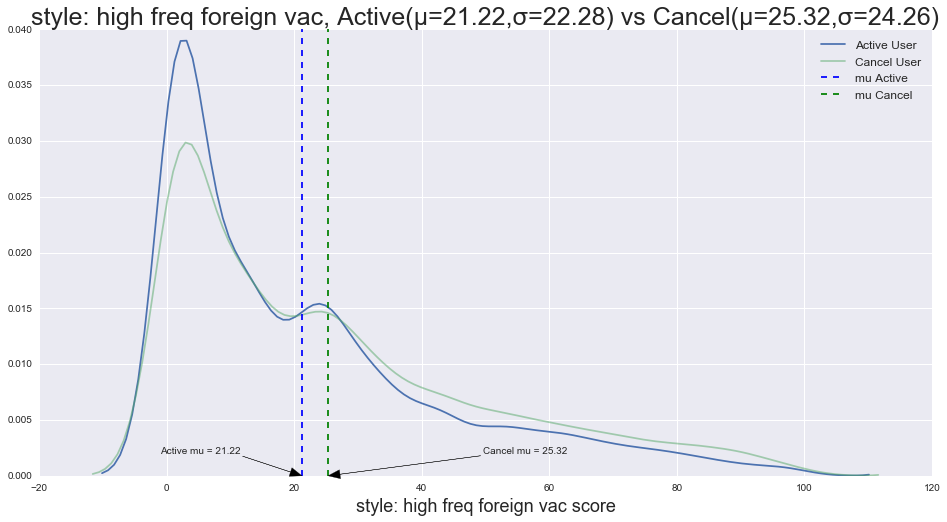

In [441]:
for column in df_num.iloc[:,2:]:
    #Looping through all numerical column in the numerical DF.
    # Assign Active user data to A, Cancel User data to B
    A = df_num_act[column]
    B = df_num_cnl[column]
    #Call the compare_distribution to create the plot.
    compare_distribution(A,B)
    
    # Split the column name, use only text after ":" as image name.
    plt.savefig("../image/{}.png".format(column.split(":")[1]))

Confirm all images properly store in the image folder

In [442]:
%ls "../image"

 cat owners.png               warehouse club members.png
 coupon users.png             wine lovers.png
 do-it-yourselfers.png       Description.png
 dog owners.png              corr heatmap.png
 health well being.png       data structure.png
 high freq domestic vac.png  data transform.png
 high freq foreign vac.png   eats family restaurant.png
 hunting enthusiasts.png     eats fast food.png
 laptop owners.png           experian.png
 life ins policy.png         home improve spenders.png
 medical policy.png          missing data.png
 medicare policy.png         null and alt.png
 security sys owners.png     sample scatter.png
 technology adoption.png     video gamer.png


Examine each image, below are another two example of image created.
One is for "video gamer", and the other one is for "dog owner".

<img src="../image/video gamer.png">
<img src="../image/ dog owners.png">

From the above images, we can see both user group actually has pretty similar distribution shape. 
<BR>
However, for "video gamer" column, the mean is far more apart then the "dog owners" column. 

### Correlation between numerical variable.
Since we are at the exploring data process, we want to see if there is any correlation between the datas. In the future, if a model is need to be build upon the data, we might able to identify some collinearity relationship here.

To do so, I decide to create a correlation heat map to identify these relationship. 

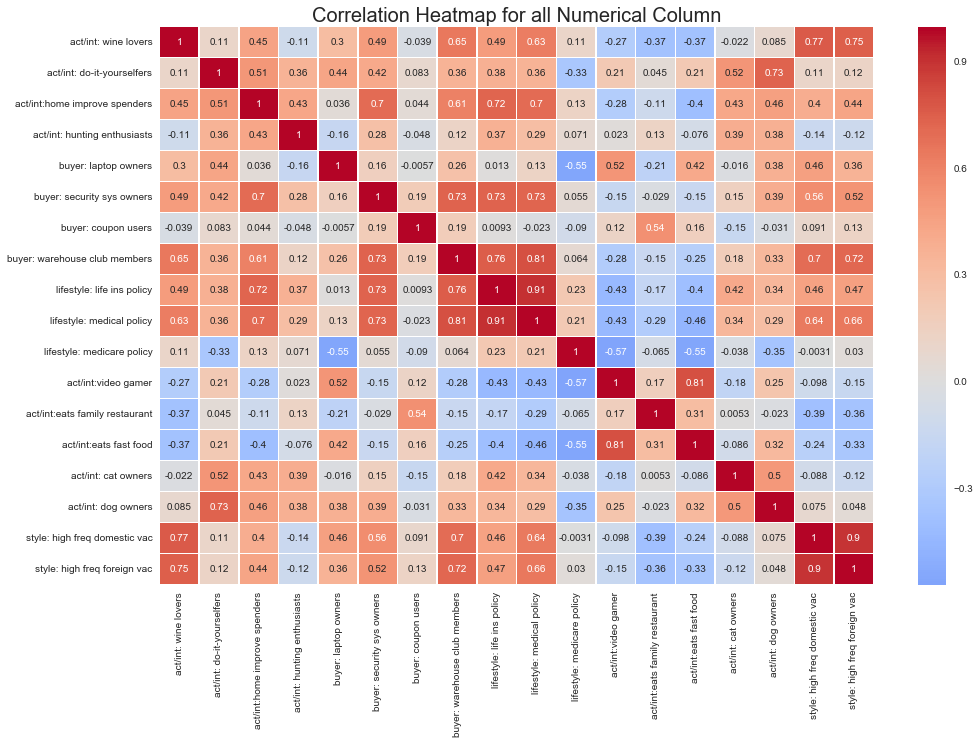

In [443]:
plt.figure(figsize=(16,10))
plt.title("Correlation Heatmap for all Numerical Column", fontsize = 20)
sns.heatmap(df_num.iloc[:,:].corr(),annot=True,linewidths=.5,center = 0, cmap="coolwarm")

Looking at the correlation heatmap above, we can definitely see some varible with strong correlation.

For example, the "medical policy" and "life insurance policy" has a correlation of 0.91. Creating a scatter plot below. 

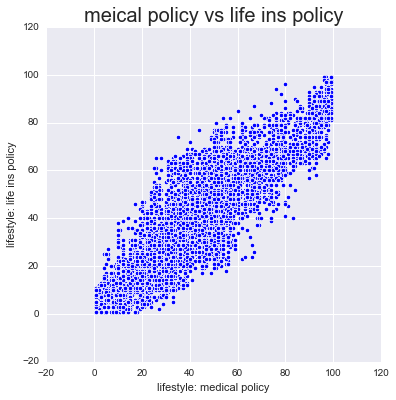

In [456]:
plt.figure(figsize=(6,6))
plt.title("meical policy vs life ins policy", fontsize= 20)
sns.scatterplot(df_num["lifestyle: medical policy"],df_num["lifestyle: life ins policy"])

From the above scatterplot, we can see the strong postive correlation.
<BR>
As one varible increase, the other tend to increase as well.
<BR>
This make sense, since both insurance usually come together.

We can use the same technique to examine other pairs with high correlation as well. By doing so, it might reduce the effect of collinearity for a better model fit in the future.

## Hypothesis Testing

Since the goal is to find out if there is really a difference between the mean score of Active group and Cancel group. A significance test is needed to get the answer. I will perform the test on two column here, but it can apply to all. Since the sample size is really large in this data,8700 for the active group and 8596 for the cancel group. I will just use Z-test since there will be nearly no differnce in the result.

The null and alternative hypothesis is:

$$ H_0: \mu_\text{Active} =  \mu_\text{Cancel} $$
$$ H_A: \mu_\text{Active} \neq  \mu_\text{Cancel} $$

I will also set the alpha for the Z-test to be 0.02.

The two column to perform the test below will be the "wine lover" and "dog owners" columns 

First I create a z_test function

In [450]:
def z_test(data1, data2):
    """
    Take two data array, 
    return the z-score and p-value
    
    Parameters
    ----------
    data1: 1-dimensional Array, numpy Array, Pandas Series.
    data2: 1-dimensional Array, numpy Array, Pandas Series.

    Returns
    -------
    dicionary(z-score:value, p-value:value)
    
    """
    numerator = np.mean(data1) - np.mean(data2)
    denominator_sq = (np.var(data1) / len(data1)) + (np.var(data2) / len(data2))
    z_score = numerator / np.sqrt(denominator_sq)
    return {"z-score":z_score,"p-value":"{:.4f}".format(stats.norm.cdf(-abs(z_score)))}


For "wine lover" column, we first look at the shape of data, since it's highly positive skew, I will perform a square root transformation on the data, the result will display below. 

Text(0.5, 1.0, 'KDE Plot for Square Root of Wine Lovers Score, Active vs Cancel')

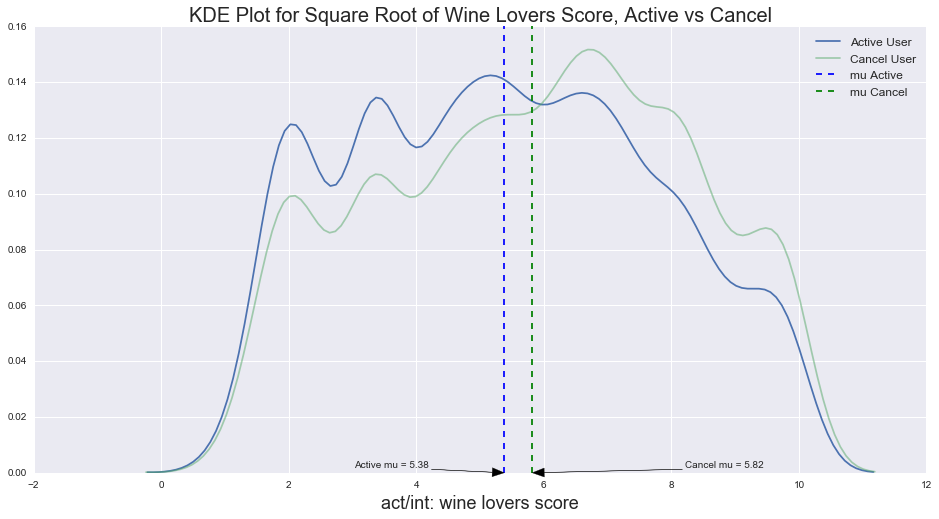

In [446]:
compare_distribution(np.sqrt(df_num_act["act/int: wine lovers"]),np.sqrt(df_num_cnl["act/int: wine lovers"]))
plt.title("KDE Plot for Square Root of Wine Lovers Score, Active vs Cancel",fontsize = 20)

The shape of the data looks symetric after the transformation, so we can approximate the data with a normal distubuiton.

Calling the z-test function to test if mean score of wine lover score between the Active and Cancel user group yields: 

In [451]:
z_test(np.sqrt(df_num_act["act/int: wine lovers"]),
       np.sqrt(df_num_cnl["act/int: wine lovers"]))

{'z-score': -12.196206798024642, 'p-value': '0.0000'}

We get a result of Z = -12.196, p-vluae = 0.

At $\alpha$=0.02, a p-value of 0.0000 means we reject the null hypothesis test, it's really likely there is a difference between the mean wine lover score between the active group and cancel group. 

Apply the same treatment for the dog owner column. 
<BR>
Since the distribution of the data is already symmetric, transformation of data is not needed.

In [452]:
z_test(np.sqrt(df_num_act["act/int: dog owners"]),
       np.sqrt(df_num_cnl["act/int: dog owners"]))

{'z-score': 1.1322649384147367, 'p-value': '0.1288'}

For the dog owner column, we get a result of Z = 1.132, p-vluae = 01288.

At $\alpha$=0.02, a p-value of 0.1288 means we fail to reject the null hypothesis test, we can't say there is a difference between the mean dog owner score between the active and cancel group.  

### Confidence interval
In the above significance test, we conclue there is a likely a difference in mean wine lover score between the two group. <BR>
    
But in order to convince other member in the company to take action on it, it is better to provide a confidence interval, the confidence interval provide more context on how much the expect difference going to be.

In [453]:
def calc_ci(data1, data2, confidence=0.95):
    """
    Take two data arary, the confidence level
    return the confidence interval
    
    Parameters
    ----------
    data1: 1-dimensional Array, numpy Array, Pandas Series.
    data2: 1-dimensional Array, numpy Array, Pandas Series.
    confidence: the Confidence level

    Returns
    -------
    tuple of confidence interval
    
    """
    mu = np.mean(data1) - np.mean(data2)
    se = np.sqrt((np.var(data1) / len(data1)) + (np.var(data2) / len(data2)))
    crit_val = abs(stats.norm.ppf((1-confidence)/2))
    lower = (mu-crit_val*se).round(4)
    upper = (mu+crit_val*se).round(4)
    return (lower,upper)

Call the calc_ci function on the square root of "wine lovers" column

In [454]:
calc_ci(np.sqrt(df_num_act["act/int: wine lovers"]),
       np.sqrt(df_num_cnl["act/int: wine lovers"]))

(-0.5099, -0.3687)

Since this is a square root of the data, the range will be from 1 to 10.

A confidence interval like this mean:
At a scale of 10, we are 95% confidence that the true mean difference between the active group and cancel group is between (-0.5099, -0.3687). In context, the lower the score, the more likely the person is a "Wine Lover", so the active group is more likely to be a wine person.

## Future Work
- Split into subgroups depend on type of subscription.
- Examine all data provide by Experian.
- Create a prediction model. 